## Ablation Experiment

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [22]:
from copy import deepcopy
import os
import numpy as np
import pandas as pd
import torch
from matplotlib import pyplot as plt
import seaborn as sns

from lib.problems import ProblemDataset, Generator, eval_cop, sub_sample
from lib.utils import CCPInstance
from baselines.utils import eval_method
from lib.ltr.utils import load_model
from lib.ltr.ccp.method import CKMeans

### Shanghai

In [3]:
DSET = "shanghai_telecom" #
CAP = 1.1
DATA_PTH = f"data/CCP/benchmark/{DSET}/data_norm_cap{CAP}_.dat"
COLS = ["num_users", "x_coord", "y_coord", "normalized_workload"]

SAMPLING_METHOD = "quadrant_rnd"
TRGT_SIZE = 50
SIZE = 250

SEED = 111
N = 200
WF = (1.5, 4.0)
FULL_K = 40
MAX_W = 0.2
INF = float("inf")

save_pth = f"./data/CCP/ablation/{DSET}_{N}"
fname = f"abl_n{N}_s{TRGT_SIZE}_cap{str(CAP).replace('.', '_')}_seed{SEED}"

os.makedirs(save_pth, exist_ok=True)

In [4]:
# load original data
data = torch.load(DATA_PTH)
print(len(data))
xyw = data[:, 1:]
rng = np.random.RandomState(SEED)


2373


In [5]:
samples = sub_sample(
    deepcopy(xyw),
    size=SIZE,
    n=N,
    rng=rng,
    method=SAMPLING_METHOD,
    weight_factor=WF,
    max_weight=MAX_W
)
# convert to CCPInstances
instances = [
    CCPInstance(
        coords=s[:, :2],
        demands=s[:, -1],
        graph_size=N,
        constraint_value=1.0,
        )
    for s in samples
]



In [6]:
K_NOT_KNOWN = False
CUDA = False
NSEEDS = 1
NUM_INIT = 8
ITERS = 50
TOL = 0.0   # no early stopping
SAVE_DIR = os.path.join(save_pth, fname)

In [7]:
metrics = {}
RESULTS = {}
seeds = [SEED * i for i in range(1,4)]
ds = ProblemDataset(problem="ccp", seed=SEED)
ds.size = len(instances)
ds.data = instances


In [8]:
## reload

def to_instance(d: dict):
    d.pop("problem")
    d.pop("size")
    gs = int(d['graph_size'])
    d['graph_size'] = gs
    d['constraint_value'] = float(d['constraint_value'])
    d['num_components'] = int(d['num_components'])
    d['coords'] = d['coords'].reshape(gs, 2)
    d['demands'] = d['demands'].reshape(gs)
    return CCPInstance(**d)

all_res = torch.load("data/CCP/ablation/shanghai_telecom_200/abl_n200_s50_cap1_1_seed999/ncc_greedy/eval_results_full_1.pkl")
data = [to_instance(e['instance']) for e in all_res]
ds.size = len(data)
ds.data = data
ds.data[0]

CCPInstance( coords=ndarray_[200, 2],  demands=ndarray_[200],  graph_size=200,  constraint_value=1.0,  labels=None,  num_components=12)

In [9]:
# checkpoints for different K in KNN
CKPTS = {
10: "outputs/ablation/shanghai_tel_ccp_200/gnn_pool_pointwise/2023-03-21_08-44-36_500369/checkpoints/epoch=197_val_acc=0.9796.ckpt",
25: "outputs/ablation/shanghai_tel_ccp_200/gnn_pool_pointwise/2023-03-21_16-24-10_812025/checkpoints/epoch=190_val_acc=0.9794.ckpt",
50: "outputs/ablation/shanghai_tel_ccp_200/gnn_pool_pointwise/2023-03-21_17-04-42_231773/checkpoints/epoch=194_val_acc=0.9795.ckpt"
}

In [10]:
# greedily assigns the last 'opt_last_frac' fraction of total nodes
# ordered by their absolute priority to the closest center

mthd = "ncc_greedy"
for knn, ckpt in CKPTS.items():
    model = load_model("ccp", ckpt)
    m_id = f"{mthd}_{knn}{'_cuda' if CUDA else ''}"

    ckmeans = CKMeans(
        model=model,
        seed=SEED,
        verbose=False,
        ###
        num_init=NUM_INIT,
        max_iter=ITERS,
        tol=TOL,
        init_method="ckm++",
        nbh_knn=int(knn),
        ###
        vanilla_priority=False,
        opt_last_frac=0.25, #7,
        opt_last_samples=1, # no multiple samples
        opt_last_prio=True
    )

    result, smry = eval_method(
        method=ckmeans.inference,
        dataset=ds,
        seeds=seeds,
        save_dir=SAVE_DIR,
        cuda=CUDA,
        k_not_known=K_NOT_KNOWN,
        method_str=mthd,
    )
    RESULTS[m_id] = result
    # check if there are any infeasible instances and replace cost with base cost
    res = deepcopy(result)
    costs = np.array([r['tot_center_dist'] for r in res])
    costs = costs.reshape(NSEEDS, -1)
    smry['center_dist_mean'] = np.mean(costs)
    smry['center_dist_std'] = np.mean(np.std(costs, axis=0))
    print(f"{m_id} summary: {smry}")
    metrics[m_id] = smry

loading model checkpoint: outputs/ablation/shanghai_tel_ccp_200/gnn_pool_pointwise/2023-03-21_08-44-36_500369/checkpoints/epoch=197_val_acc=0.9796.ckpt
evaluating baseline: 'ncc_greedy'
loaded test data: ccp200 -> 
running method for 3 seeds on 50 instances...
Running eval for seed 111...


100%|██████████| 50/50 [01:58<00:00,  2.37s/it]


Running eval for seed 222...


100%|██████████| 50/50 [01:55<00:00,  2.31s/it]


Running eval for seed 333...


100%|██████████| 50/50 [01:55<00:00,  2.30s/it]


-----------------------------------------
ncc_greedy_10 summary: {'center_dist_mean': 0.5550157378150639, 'center_dist_std': 0.0, 'nc_mean': 8.66, 'nc_std': 2.5108564275959706, 'nc_median': 9.0, 'run_time_mean': 2.3257552177065617, 'run_time_total': 348.8632826559842, 'num_infeasible': 0}
loading model checkpoint: outputs/ablation/shanghai_tel_ccp_200/gnn_pool_pointwise/2023-03-21_16-24-10_812025/checkpoints/epoch=190_val_acc=0.9794.ckpt
evaluating baseline: 'ncc_greedy'
loaded test data: ccp200 -> 
running method for 3 seeds on 50 instances...
Running eval for seed 111...


100%|██████████| 50/50 [02:06<00:00,  2.54s/it]


Running eval for seed 222...


100%|██████████| 50/50 [02:07<00:00,  2.56s/it]


Running eval for seed 333...


100%|██████████| 50/50 [02:07<00:00,  2.54s/it]


-----------------------------------------
ncc_greedy_25 summary: {'center_dist_mean': 0.5506750441212112, 'center_dist_std': 0.0, 'nc_mean': 8.66, 'nc_std': 2.5108564275959706, 'nc_median': 9.0, 'run_time_mean': 2.5450580600268826, 'run_time_total': 381.7587090040324, 'num_infeasible': 0}
loading model checkpoint: outputs/ablation/shanghai_tel_ccp_200/gnn_pool_pointwise/2023-03-21_17-04-42_231773/checkpoints/epoch=194_val_acc=0.9795.ckpt
evaluating baseline: 'ncc_greedy'
loaded test data: ccp200 -> 
running method for 3 seeds on 50 instances...
Running eval for seed 111...


100%|██████████| 50/50 [02:26<00:00,  2.94s/it]


Running eval for seed 222...


100%|██████████| 50/50 [02:27<00:00,  2.95s/it]


Running eval for seed 333...


100%|██████████| 50/50 [02:28<00:00,  2.97s/it]

-----------------------------------------
ncc_greedy_50 summary: {'center_dist_mean': 0.546779543320701, 'center_dist_std': 0.0, 'nc_mean': 8.66, 'nc_std': 2.5108564275959706, 'nc_median': 9.0, 'run_time_mean': 2.950066822659234, 'run_time_total': 442.5100233988851, 'num_infeasible': 0}


In [12]:
# samples multiple assignments for the last 'opt_last_frac' fraction of total nodes
# and selects the best one

mthd = "ncc_samp"
for knn, ckpt in CKPTS.items():
    model = load_model("ccp", ckpt)
    m_id = f"{mthd}_{knn}{'_cuda' if CUDA else ''}"

    ckmeans = CKMeans(
        model=model,
        seed=SEED,
        verbose=False,
        ###
        num_init=NUM_INIT,
        max_iter=ITERS,
        tol=TOL,
        init_method="ckm++",
        nbh_knn=int(knn),
        ###
        vanilla_priority=False,
        opt_last_frac=0.25, #,
        opt_last_samples=32, #64,
        opt_last_prio=True
    )

    result, smry = eval_method(
        method=ckmeans.inference,
        dataset=ds,
        seeds=seeds,
        save_dir=SAVE_DIR,
        cuda=CUDA,
        k_not_known=K_NOT_KNOWN,
        method_str=mthd,
    )
    RESULTS[m_id] = result
    # check if there are any infeasible instances and replace cost with base cost
    res = deepcopy(result)
    costs = np.array([r['tot_center_dist'] for r in res])
    costs = costs.reshape(NSEEDS, -1)
    smry['center_dist_mean'] = np.mean(costs)
    smry['center_dist_std'] = np.mean(np.std(costs, axis=0))
    print(f"{m_id} summary: {smry}")
    metrics[m_id] = smry

loading model checkpoint: outputs/ablation/shanghai_tel_ccp_200/gnn_pool_pointwise/2023-03-21_08-44-36_500369/checkpoints/epoch=197_val_acc=0.9796.ckpt
evaluating baseline: 'ncc_samp'
loaded test data: ccp200 -> 
running method for 3 seeds on 50 instances...
Running eval for seed 111...


100%|██████████| 50/50 [02:26<00:00,  2.93s/it]


Running eval for seed 222...


100%|██████████| 50/50 [02:24<00:00,  2.88s/it]


Running eval for seed 333...


100%|██████████| 50/50 [02:23<00:00,  2.87s/it]


-----------------------------------------
ncc_samp_10 summary: {'center_dist_mean': 0.5545545584186689, 'center_dist_std': 0.0, 'nc_mean': 8.66, 'nc_std': 2.5108564275959706, 'nc_median': 9.0, 'run_time_mean': 2.8928770776469417, 'run_time_total': 433.93156164704124, 'num_infeasible': 0}
loading model checkpoint: outputs/ablation/shanghai_tel_ccp_200/gnn_pool_pointwise/2023-03-21_16-24-10_812025/checkpoints/epoch=190_val_acc=0.9794.ckpt
evaluating baseline: 'ncc_samp'
loaded test data: ccp200 -> 
running method for 3 seeds on 50 instances...
Running eval for seed 111...


100%|██████████| 50/50 [02:35<00:00,  3.10s/it]


Running eval for seed 222...


100%|██████████| 50/50 [02:35<00:00,  3.11s/it]


Running eval for seed 333...


100%|██████████| 50/50 [02:35<00:00,  3.11s/it]


-----------------------------------------
ncc_samp_25 summary: {'center_dist_mean': 0.5395154114507923, 'center_dist_std': 0.0, 'nc_mean': 8.66, 'nc_std': 2.5108564275959706, 'nc_median': 9.0, 'run_time_mean': 3.1067432769599934, 'run_time_total': 466.011491543999, 'num_infeasible': 0}
loading model checkpoint: outputs/ablation/shanghai_tel_ccp_200/gnn_pool_pointwise/2023-03-21_17-04-42_231773/checkpoints/epoch=194_val_acc=0.9795.ckpt
evaluating baseline: 'ncc_samp'
loaded test data: ccp200 -> 
running method for 3 seeds on 50 instances...
Running eval for seed 111...


100%|██████████| 50/50 [02:54<00:00,  3.50s/it]


Running eval for seed 222...


100%|██████████| 50/50 [02:54<00:00,  3.49s/it]


Running eval for seed 333...


100%|██████████| 50/50 [02:54<00:00,  3.50s/it]

-----------------------------------------
ncc_samp_50 summary: {'center_dist_mean': 0.5421716625581292, 'center_dist_std': 0.0, 'nc_mean': 8.66, 'nc_std': 2.5108564275959706, 'nc_median': 9.0, 'run_time_mean': 3.4946570628401243, 'run_time_total': 524.1985594260186, 'num_infeasible': 0}


loading model checkpoint: outputs/ablation/shanghai_tel_ccp_200/gnn_pool_pointwise/2023-03-21_08-44-36_500369/checkpoints/epoch=197_val_acc=0.9796.ckpt
evaluating baseline: 'ncc_samp'
loaded test data: ccp200 -> 
running method for 3 seeds on 50 instances...
Running eval for seed 111...


100%|██████████| 50/50 [02:21<00:00,  2.83s/it]


Running eval for seed 222...


100%|██████████| 50/50 [02:21<00:00,  2.83s/it]


Running eval for seed 333...


100%|██████████| 50/50 [02:21<00:00,  2.83s/it]


-----------------------------------------
ncc_samp_10 summary: {'center_dist_mean': 0.5545545584186689, 'center_dist_std': 0.0, 'nc_mean': 8.66, 'nc_std': 2.5108564275959706, 'nc_median': 9.0, 'run_time_mean': 2.828842935953192, 'run_time_total': 424.32644039297884, 'num_infeasible': 0}
loading model checkpoint: outputs/ablation/shanghai_tel_ccp_200/gnn_pool_pointwise/2023-03-21_16-24-10_812025/checkpoints/epoch=190_val_acc=0.9794.ckpt
evaluating baseline: 'ncc_samp'
loaded test data: ccp200 -> 
running method for 3 seeds on 50 instances...
Running eval for seed 111...


100%|██████████| 50/50 [02:33<00:00,  3.07s/it]


Running eval for seed 222...


100%|██████████| 50/50 [02:33<00:00,  3.06s/it]


Running eval for seed 333...


100%|██████████| 50/50 [02:38<00:00,  3.17s/it]


-----------------------------------------
ncc_samp_25 summary: {'center_dist_mean': 0.5395154114507923, 'center_dist_std': 0.0, 'nc_mean': 8.66, 'nc_std': 2.5108564275959706, 'nc_median': 9.0, 'run_time_mean': 3.097812723279882, 'run_time_total': 464.6719084919823, 'num_infeasible': 0}
loading model checkpoint: outputs/ablation/shanghai_tel_ccp_200/gnn_pool_pointwise/2023-03-21_17-04-42_231773/checkpoints/epoch=194_val_acc=0.9795.ckpt
evaluating baseline: 'ncc_samp'
loaded test data: ccp200 -> 
running method for 3 seeds on 50 instances...
Running eval for seed 111...


100%|██████████| 50/50 [02:58<00:00,  3.57s/it]


Running eval for seed 222...


100%|██████████| 50/50 [02:51<00:00,  3.44s/it]


Running eval for seed 333...


100%|██████████| 50/50 [02:51<00:00,  3.43s/it]

-----------------------------------------
ncc_samp_50 summary: {'center_dist_mean': 0.5421716625581292, 'center_dist_std': 0.0, 'nc_mean': 8.66, 'nc_std': 2.5108564275959706, 'nc_median': 9.0, 'run_time_mean': 3.475987292446613, 'run_time_total': 521.398093866992, 'num_infeasible': 0}


In [13]:
# convert to dataframe for nice table ;)
metric_df = pd.DataFrame(metrics)
metric_df


,ncc_greedy_10,ncc_greedy_25,ncc_greedy_50,ncc_samp_10,ncc_samp_25,ncc_samp_50
center_dist_mean,0.555016,0.550675,0.546780,0.554555,0.539515,0.542172
center_dist_std,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
nc_mean,8.660000,8.660000,8.660000,8.660000,8.660000,8.660000
nc_std,2.510856,2.510856,2.510856,2.510856,2.510856,2.510856
nc_median,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000
run_time_mean,2.325755,2.545058,2.950067,2.828843,3.097813,3.475987
run_time_total,348.863283,381.758709,442.510023,424.326440,464.671908,521.398094
num_infeasible,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [14]:
metric_df.to_csv("outputs_eval/ablation_knn/results.csv", mode="w+")

In [44]:
ks = [int(c[-2:]) for c in metric_df.columns]
ks

[10, 25, 50, 10, 25, 50]

In [50]:
mthd_type = ["greedy" if "greedy" in c else "sampling" for c in metric_df.columns]
mthd_type

['greedy', 'greedy', 'greedy', 'sampling', 'sampling', 'sampling']

In [51]:
dist_df = metric_df.iloc[0, :].to_frame()

In [52]:
dist_df.insert(1, "k", ks)
dist_df.insert(2, "method", mthd_type)

In [53]:
dist_df

,center_dist_mean,k,method
ncc_greedy_10,0.555016,10,greedy
ncc_greedy_25,0.550675,25,greedy
ncc_greedy_50,0.546780,50,greedy
ncc_samp_10,0.554555,10,sampling
ncc_samp_25,0.539515,25,sampling
ncc_samp_50,0.542172,50,sampling


<AxesSubplot:xlabel='k', ylabel='center_dist_mean'>

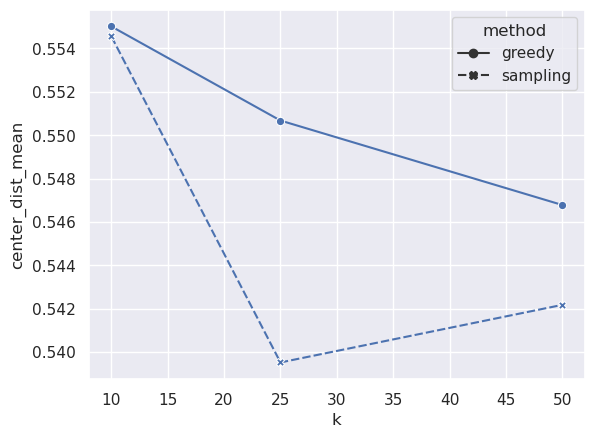

In [57]:
sns.set_theme()
sns.lineplot(data=dist_df, x="k", y="center_dist_mean", style="method", markers=True)

In [58]:
rt_df = metric_df.iloc[5, :].to_frame()
rt_df.insert(1, "k", ks)
rt_df.insert(2, "method", mthd_type)
rt_df

,run_time_mean,k,method
ncc_greedy_10,2.325755,10,greedy
ncc_greedy_25,2.545058,25,greedy
ncc_greedy_50,2.950067,50,greedy
ncc_samp_10,2.828843,10,sampling
ncc_samp_25,3.097813,25,sampling
ncc_samp_50,3.475987,50,sampling


<AxesSubplot:xlabel='k', ylabel='run_time_mean'>

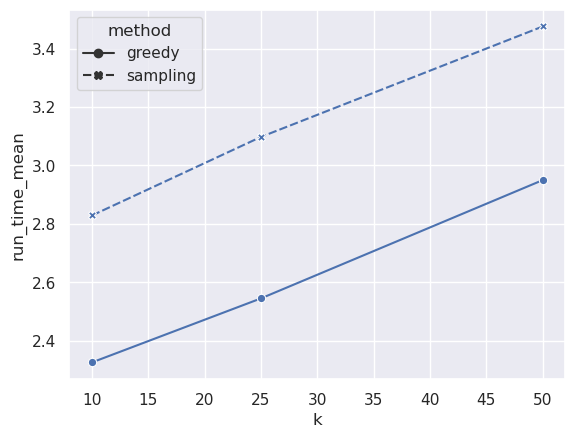

In [59]:
sns.set_theme()
sns.lineplot(data=rt_df, x="k", y="run_time_mean", style="method", markers=True)